Anweisungen von Leon MuscatNuss:

**Steps:**
1. Daten check
- Daten laden
- returns berechnen
- Visuell nach volatility clustering schauen
- Schauen ob die Daten stationary sind (mit ADF)
2. ARCH effect suchen:
- Engle's Lagrange Test
3. GARCH model wählen
- Mach simpel standard GARCH mit p und q. Starte mit 1, 1
- Berechne AIC und BIC
- Teste verschiedene GARCH modelle (also andere p und q) bis du das tiefste AIC und BIC gefunden hast
4. Residuals checken
- ACF und PACF plots visuell schauen, ob Werte außerhalb der Bounds sind

In [22]:
CSV_PATH = '../data/btcusd_1-min_data.csv'
import pandas as pd
import numpy as np

def load_data():
    df = pd.read_csv(CSV_PATH)

    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    
    df['Returns'] = df['Close'].pct_change()
    df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate volatility (absolute value of returns)
    df['Volatility'] = df['Returns'].abs()

    df.dropna(inplace=True)
    return df

df = load_data()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7013969 entries, 1 to 7013969
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Timestamp    datetime64[ns]
 1   Open         float64       
 2   High         float64       
 3   Low          float64       
 4   Close        float64       
 5   Volume       float64       
 6   Returns      float64       
 7   Log Returns  float64       
 8   Volatility   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 535.1 MB


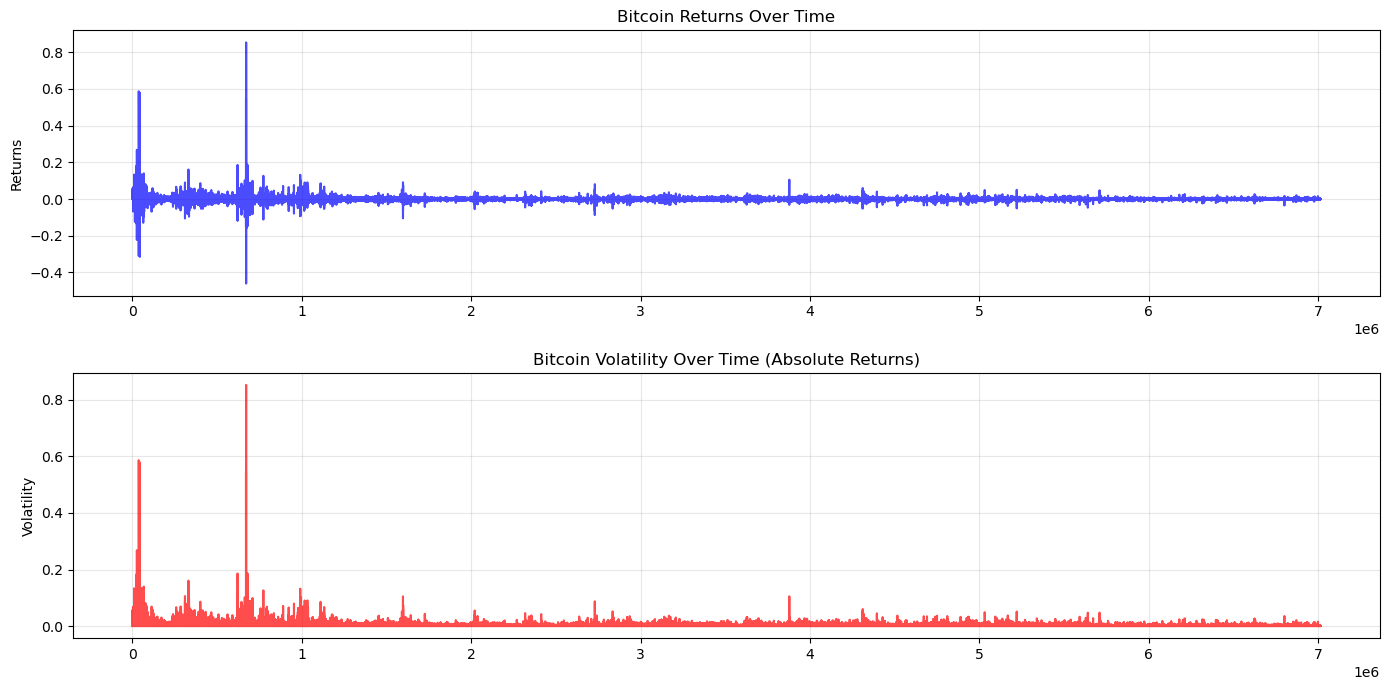

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))



# Returns over time
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Returns'], color='blue', alpha=0.7)
plt.title('Bitcoin Returns Over Time')
plt.ylabel('Returns')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Volatility'], color='red', alpha=0.7)
plt.title('Bitcoin Volatility Over Time (Absolute Returns)')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
def sample_to_x_min_intervals(df, interval=5):
   
    sampled_df = df[::interval]
    sampled_df = sampled_df.reset_index(drop=True)
    return sampled_df

# df_15min = sample_to_x_min_intervals(df, 15)

df_30min = sample_to_x_min_intervals(df, 30)

# df_60min = sample_to_x_min_intervals(df, 60)
# df_60min.info()

In [5]:
from statsmodels.tsa.stattools import adfuller

columns_to_check = ['Close', 'Returns', 'Log Returns', 'Volatility']

for column in columns_to_check:
    series = df_30min[column]

    adf_result = adfuller(series) 

    print(f"Augmented Dickey-Fuller test for {column}:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    is_stationary = adf_result[1] < 0.05
    message = f"{column} is Stationary" if is_stationary else f"{column} is not stationary"

    


Augmented Dickey-Fuller test for Close:
ADF Statistic: 0.8216068518926266
p-value: 0.9919770574382035
Augmented Dickey-Fuller test for Returns:
ADF Statistic: -47.432715973843194
p-value: 0.0
Augmented Dickey-Fuller test for Log Returns:
ADF Statistic: -46.559251436363134
p-value: 0.0
Augmented Dickey-Fuller test for Volatility:
ADF Statistic: -24.71611643882057
p-value: 0.0


In [9]:
from statsmodels.stats.diagnostic import het_arch

columns_to_check = ['Returns', 'Log Returns']


for column in columns_to_check:
    series = df[column]

    arch_test = het_arch(series)
    print(f"ARCH Test for {column}:")
    print(f"ARCH Test Statistic: {arch_test[0]}")
    print(f"ARCH Test p-value: {arch_test[1]}")
    is_arch = arch_test[1] < 0.05
    message = f"{column} series is ARCH" if is_arch else f"{column} series is not ARCH"
    print(message)



ARCH Test for Returns:
ARCH Test Statistic: 326298.2305508871
ARCH Test p-value: 0.0
Returns series is ARCH
ARCH Test for Log Returns:
ARCH Test Statistic: 1169751.9026083744
ARCH Test p-value: 0.0
Log Returns series is ARCH


In [ ]:
scaled_returns = df['Returns'] * 10000
returns = scaled_returns.dropna()

split_index = int(len(returns) * 0.8)
train_series, test_series = returns[:split_index], returns[split_index:]

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.26282e+07
Distribution:                  Normal   AIC:                       4.52563e+07
Method:            Maximum Likelihood   BIC:                       4.52564e+07
                                        No. Observations:              5611175
Date:                Sun, May 04 2025   Df Residuals:                  5611175
Time:                        14:49:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          8.2097      1.004      8.179  2.870e-16    

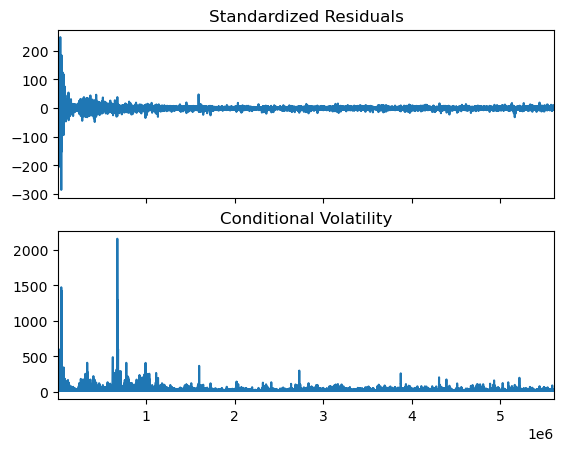

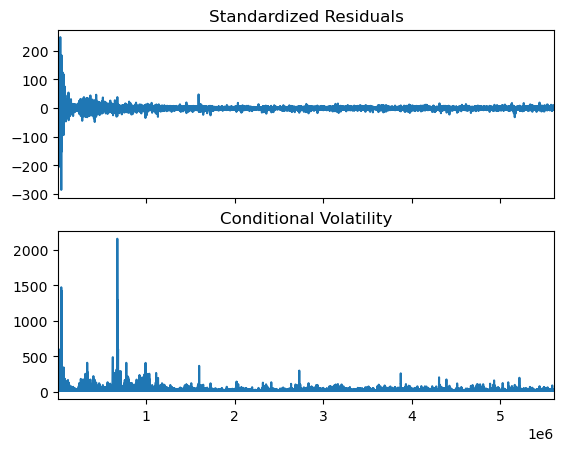

In [20]:
from arch import arch_model

# Fit GARCH(1, 1) model



model = arch_model(train_series, vol='Garch', p=1, q=1, mean='Zero', dist='Normal')
model_fit = model.fit(disp="off")

print(model_fit.summary())

model_fit.plot() 


##new approach for log returns

In [66]:
hourly_data = sample_to_x_min_intervals(df, 60)

hourly_log_returns_series = hourly_data['Log Returns'].dropna()

q5, q95 = np.percentile(hourly_log_returns_series, [5, 95])
print(f"5th Percentile: {q5}")
print(f"95th Percentile: {q95}")

filtered_log_returns = hourly_log_returns_series[(hourly_log_returns_series > q5) & (hourly_log_returns_series < q95)]


split_index = int(len(filtered_log_returns) * 0.8)
train_series, test_series = filtered_log_returns[:split_index], filtered_log_returns[split_index:]





5th Percentile: -0.001958008360346296
95th Percentile: 0.0019531268112996957


In [67]:
import itertools
import pandas as pd
from arch import arch_model

# Simple parameter grids
p_values = [1, 2, 3, 4]
q_values = [1, 2,3, 4]
mean_models = ['Zero', 'Constant']
distributions = ['Normal', 'StudentsT']

# Prepare all combinations of parameters for the grid search
all_params = list(itertools.product(p_values, q_values, mean_models, distributions))

# Placeholder for results
results = []


# Serial evaluation of models
for params in all_params:
    p, q, mean_model, distribution = params
    try:
        # Define the model
        model = arch_model(train_series, vol='Garch', p=p, q=q, mean=mean_model, dist=distribution, rescale=True)
        
        # Fit the model
        model_fit = model.fit(disp="off", options={'maxiter': 1000})
        
        # Get AIC and BIC
        aic = model_fit.aic
        bic = model_fit.bic
        
        # Store the results
        results.append((p, q, mean_model, distribution, aic, bic))
    except Exception as e:
        # In case of failure, append None for AIC/BIC
        results.append((p, q, mean_model, distribution, None, None))

# Create DataFrame from results
results_df = pd.DataFrame(results, columns=['p', 'q', 'mean_model', 'distribution', 'AIC', 'BIC'])

# Find the best model based on AIC (or BIC)
best_model = results_df.loc[results_df['AIC'].idxmin()]
print("Best Model by AIC:")
print(best_model)


/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best Model by AIC:
p                           3
q                           4
mean_model           Constant
distribution        StudentsT
AIC             124544.425062
BIC             124637.830763
Name: 47, dtype: object


/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [68]:
from arch import arch_model

# Fit the best model to the training data
best_model = arch_model(train_series, vol='Garch', p=3, q=4, mean='Constant', dist='StudentsT', rescale=True)
best_model_fit = best_model.fit(disp="off")

# Display the fit summary
print(best_model_fit.summary())

print("Model AIC:", best_model_fit.aic)
print("Model BIC:", best_model_fit.bic)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Log Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -62262.2
Distribution:      Standardized Student's t   AIC:                           124544.
Method:                  Maximum Likelihood   BIC:                           124638.
                                              No. Observations:                84168
Date:                      Sun, May 04 2025   Df Residuals:                    84167
Time:                              15:26:44   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [69]:
# Forecasting the next values (e.g., 1-step ahead forecast)
forecast = best_model_fit.forecast(horizon=len(test_series))

# Extract the forecasted volatility (or other metrics)
forecasted_volatility = forecast.variance[-len(test_series):]  # Extract variance forecast
print(forecasted_volatility)


        h.00001   h.00002   h.00003   h.00004   h.00005   h.00006   h.00007  \
95373  0.405692  0.435365  0.381993  0.406824  0.406515  0.404758  0.400321   

        h.00008   h.00009   h.00010  ...   h.21033   h.21034   h.21035  \
95373  0.403452  0.402592  0.401686  ...  0.360787  0.360787  0.360787   

        h.21036   h.21037   h.21038   h.21039   h.21040   h.21041   h.21042  
95373  0.360787  0.360787  0.360787  0.360787  0.360787  0.360787  0.360787  

[1 rows x 21042 columns]


In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

std_resid = best_model_fit.std_resid
print(acorr_ljungbox(std_resid, lags=[10], return_df=True))
print(acorr_ljungbox(std_resid**2, lags=[10], return_df=True))


     lb_stat  lb_pvalue
10  8.191073   0.610179
       lb_stat     lb_pvalue
10  101.554216  2.661452e-17


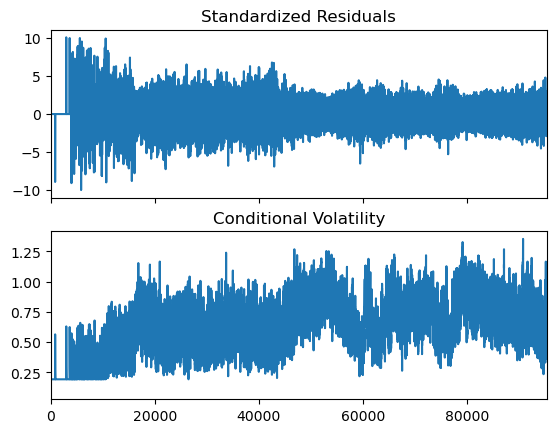

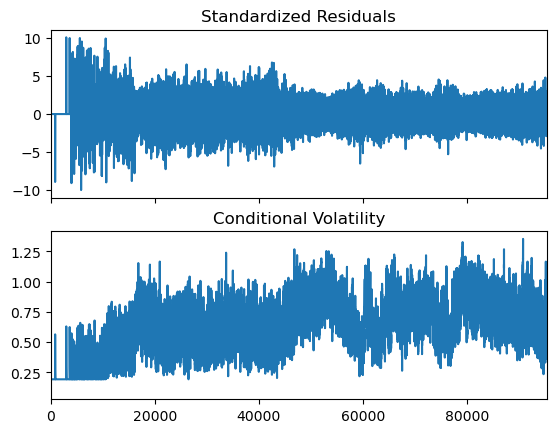

In [71]:
best_model_fit.plot()

In [81]:
mean = np.mean(test_series)
print("Mean of test series:", mean)

np.var(test_series)
print("Variance of test series:", np.var(test_series))
np.var(test_series - mean)
print("Variance of test series - mean:", np.var(test_series - mean))

print(len(test_series))

Mean of test series: 6.225715577937984e-07
Variance of test series: 2.922833359465402e-07
Variance of test series - mean: 2.922833359465402e-07
21042


In [ ]:
predicted_variances = []
realized_variances = []
forecast_errors = []

test_values = test_series.values

rolling_series = train_series.copy()

for i in range(0,len(test_values),1):
    model = arch_model(rolling_series, vol='Garch', p=3, q=4, mean='Constant', dist='StudentsT', rescale=True)
    model_fit = model.fit(disp="off")
    
    forecast = model_fit.forecast(horizon=10)
    predicted_var = forecast.variance.iloc[-1, 0]
    predicted_variances.append(predicted_var)

    # Store realized variance
    realized_var = test_values[i] ** 2
    realized_variances.append(realized_var)

    # Store error
    error = realized_var - predicted_var
    forecast_errors.append(error)
    
    # Add the actual return to the rolling window
    rolling_series = pd.concat([rolling_series, pd.Series(test_values[i])])
    if i % 1000 == 0:
        print(f"completed {i} of {len(test_values)}")
    


plt.figure(figsize=(10, 4))
plt.plot(test_values**2, label='Realized Variance (Test)')
plt.plot(predicted_variances, label='Predicted Variance (GARCH)', alpha=0.7)
plt.legend()
plt.title('Rolling GARCH Predicted vs Realized Variance')
plt.show()



completed 0 of 21042


/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/FTS/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize

KeyboardInterrupt: 

In [86]:
import numpy as np


predicted_variances = np.array(predicted_variances)
realized_variances = np.array(realized_variances)


mse = np.mean(np.square(forecast_errors))
print(f"MSE: {mse:.4e}")

mae = np.mean(np.abs(forecast_errors))
print(f"MAE: {mae:.4e}")


qlike = np.mean(np.log(predicted_variances) + realized_variances / predicted_variances)
print(f"QLIKE: {qlike:.4f}")


MSE: 3.7118e+15
MAE: 1.2989e+07
QLIKE: -0.0592
